# 2. Apricot dataset -> Pillow's format

Here we manipulate the apricot dataset into a more concise form ("Pillow's format")

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as spio

datafile = 'mosaicGLM_apricot_ONParasol-1-mat.mat'
data = spio.loadmat(datafile)
data = data['mosaicGLM'][0]
len(data)

94

Now we have the data loaded. The fitted parameters are under the first element ("linearfilters") 

In [2]:
cellnum = 16
i = 0
len(data[cellnum][0][0][i][0][0])

4

The four elements here are: note + TonicDrive, PostSpike and Stimulus filters.
Let's first extract tonic drive.

In [3]:
tonicdrive = data[cellnum][0][0][i][0][0][1][0][0][0][0][0]
print tonicdrive

1.49056970987


Let's then see what the postspike filter looks like (there's a refractory period!)

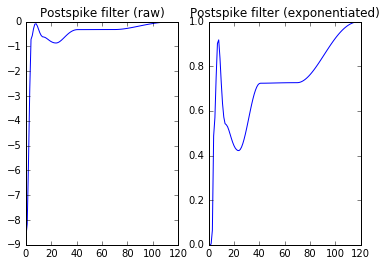

In [4]:
postspike_filter = data[cellnum][0][0][i][0][0][2][0][0][0]
plt.subplots(1,2)
plt.subplot(121)
plt.title('Postspike filter (raw)')
plt.plot(range(len(postspike_filter)), postspike_filter)

plt.subplot(122)
plt.title('Postspike filter (exponentiated)')
plt.plot(range(len(postspike_filter)), np.exp(postspike_filter))

The spatiotemporal stimulus filter in this dataset is 13x13 pixels while the whole pixel grid is 80x40. Thus, in addition to extracting filter parameters we need to extract the filter coordinates. Temporal filter goes 15 time bins back (with 120 Hz sampling, 1 bin = 8.333 ms).

In [5]:
stimulus_filter = data[cellnum][0][0][i][0][0][3][0][0][0]
np.shape(stimulus_filter)

(13L, 13L, 15L)

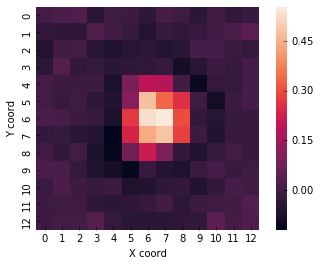

In [6]:
import seaborn as sns
sns.heatmap(stimulus_filter[:,:,1].T, square=True)
plt.xlabel('X coord')
plt.ylabel('Y coord')

Then, we should extract the absolute coordinates

In [7]:
x_coords = data[cellnum][0][0][i][0][0][3][0][0][4]
y_coords = data[cellnum][0][0][i][0][0][3][0][0][5]
x_center = np.median(x_coords)
x_min = np.min(x_coords)
y_center = np.median(y_coords)
y_min = np.min(y_coords)
print 'X center: %d\t Y center: %d' % (x_center, y_center)
print 'X    min: %s\t Y    min: %s' % (x_min, y_min)

X center: 57	 Y center: 32
X    min: 51	 Y    min: 26


Then the full stimulus filter at t=1 looks like this:

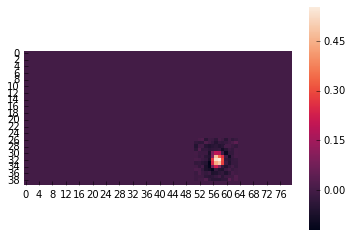

In [8]:
A = np.zeros((80,40))
A[x_min:x_min+13, y_min:y_min+13] = stimulus_filter[:,:,1]
sns.heatmap(A.T, square=True)

We can also linearize the 13x13-pixel 2D grid to fit time in the same heatmap

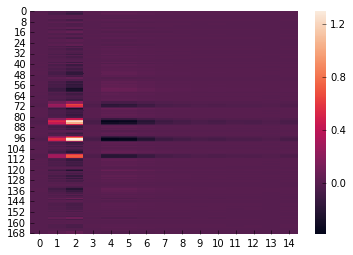

In [9]:
stimulus_filter_1d = np.reshape(stimulus_filter, (13*13, 15))  # 13x13 = 169
sns.heatmap(stimulus_filter_1d)

Gather data for all cells in the dataset...

In [10]:
N_cells = 50

tonicdrive_all = []
stimfilter_all = []
postspike_all = np.zeros((120, N_cells, N_cells))  # N_cells-by-N_cells matrix with diag. containing spikehist filt
rf_center_all = np.zeros([N_cells,2])
rf_sd_xy_all = np.zeros([N_cells,2])
rf_rot_all = np.zeros(N_cells)

#for cellnum in range(len(data)):
for celln in range(N_cells):
    tonicdrive = data[celln][0][0][i][0][0][1][0][0][0][0][0]
    postspike_filter = data[celln][0][0][i][0][0][2][0][0][0]
    stimulus_filter = data[celln][0][0][i][0][0][3][0][0][0]
    
    x_coords = data[celln][0][0][i][0][0][3][0][0][4]
    y_coords = data[celln][0][0][i][0][0][3][0][0][5]
    x_center = np.median(x_coords)
    x_min = np.min(x_coords)
    y_center = np.median(y_coords)
    y_min = np.min(y_coords)
    
    A = np.zeros((81,41,15))  # Padded matrix so that stimulus filter can be inserted without error
    A[x_min:x_min+13, y_min:y_min+13, :] = stimulus_filter[:,:,:]
    A = A[:80,:40,:]
    stimulus_filter_1d = np.reshape(A, (80*40,15))
    stimulus_filter_1d = np.fliplr(stimulus_filter_1d)  # Flip over axis 1; In Pillow's code, most recent is last in indexing
    
    tonicdrive_all.append(tonicdrive)
    stimfilter_all.append(stimulus_filter_1d)
    postspike_all[:, cellnum, cellnum] = np.array(postspike_filter[:,0])

    # Let's still add fitted RF parameters
    cellgeom = {'center_x':   data[celln][0][0][3][0][0][0][0][0], 
                'center_y':   data[celln][0][0][3][0][0][1][0][0], 
                'sd_x':       data[celln][0][0][3][0][0][2][0][0],
                'sd_y':       data[celln][0][0][3][0][0][3][0][0], 
                'center_rot': data[celln][0][0][3][0][0][4][0][0]}
    
    rf_center_all[celln] = [cellgeom['center_x'], cellgeom['center_y']]
    rf_sd_xy_all[celln] = [cellgeom['sd_x'], cellgeom['sd_y']]
    rf_rot_all[celln] = cellgeom['center_rot']
    

print np.shape(stimfilter_all)
print np.shape(postspike_all)

(50L, 3200L, 15L)
(120L, 50L, 50L)


Let's finally twist everything into Pillow's format: time first, then pixels in 1d, and cell index last.
Then check that everything looks like before.

(15L, 3200L, 50L)
(1L, 50L)


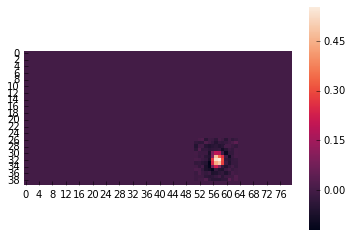

In [11]:
stimfilter_all = np.transpose(np.array(stimfilter_all))
tonicdrive_all = np.reshape(np.array(tonicdrive_all),(1, N_cells))

print np.shape(stimfilter_all)
print np.shape(tonicdrive_all)

sns.heatmap(np.reshape(stimfilter_all[13,:,cellnum], (80, 40)).T, square=True)

In [12]:
postspike_sampling = np.array([np.arange(0, 12., 0.1)]).T  # Without dot saves as int -> Matlab does rounded division
glm_dict = {'glmstruct': {'dc': tonicdrive_all,
                          'ih': postspike_all,
                          'k': stimfilter_all,
                          'iht': postspike_sampling,
                          'rf_center': rf_center_all,
                          'rf_sd_xy': rf_sd_xy_all,
                          'rf_rotation': rf_rot_all}}
spio.savemat('apricot_onparasol_ih12_geom.mat', glm_dict)